# Logistic Regression

In [1]:
import torch
import torch.nn as nn # neural network
from torch.autograd import Variable # gradient, türev hesabı için
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd # veriyi import etmek için
import numpy as np

from sklearn.model_selection import train_test_split # veriyi train ve test olarak ayıracağım

import matplotlib.pyplot as plt

## Problem Tanımı ve Veri Seti Hazırlama (Preprocess)

* MNIST veri seti, 28x28 piksel boyutunda siyah-beyaz (gray-scale) resimler içerir. Toplam piksel sayısı 28x28 = 784'tür.
* Bu veri setinde yer alan resimler el yazısıyla yazılmış rakam görsellerini içerir (0-9 arası rakamlar).
* Dolayısıyla, bu veri setinde 10 farklı sınıf bulunur, her sınıf bir rakamı temsil eder (0-9).
* Renk tonları, siyahtan (0) beyaza (255) kadar değişir, arada farklı gri tonları bulunur.
* Toplamda 785 sütun bulunur. İlk sütun, resmin sınıfını belirten etiketi (label) içerir. Diğer sütunlarda ise resmin her pikselinin değeri bulunur.

In [2]:
train = pd.read_csv(r"train.csv", dtype = np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
targets_numpy = train.label.values
targets_numpy[:5] # label sütunu

array([1., 0., 1., 4., 0.], dtype=float32)

In [4]:
# label sütunu dışındaki bütün değerleri (piksel değerleri) al ve normalize et
features_numpy = train.loc[:, train.columns != "label"].values / 255 # normalizasyon

In [5]:
# %20 test veri seti olsun
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                              targets_numpy,
                                                                              test_size = 0.2,
                                                                              random_state = 42)

In [6]:
# pytorch kütüphanesinde gradient hesabı (türev) yapabilmek ve bunları biriktirebilmek için 
# variable veri yapısına ihtiyacımız vardır. bunun için ilk önce tensor'lere dönüştürelim

In [7]:
# numpy -> tensor
featuresTrain = torch.from_numpy(features_train) # tensor
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # tensor

In [8]:
featuresTrain.shape # toplam resim/örnek sayısı (satır) : 33600
# 1 resimdeki toplam piksel sayısı 784 (28*28)

torch.Size([33600, 784])

In [9]:
# numpy -> tensor
featuresTest = torch.from_numpy(features_test) # tensor
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # tensor

**Batch Boyutu (batch_size):**
* Veriyi eğitim işlemini gerçekleştirmek için kaç parçaya böleceğimizi belirler.
* Örneğin, elimizde 1000 örnek veri varsa ve batch boyutunu 10 olarak seçersek, her bir batch (grup) içinde 100 örnek bulunur.
* Bu 10 grup sırayla eğitim işlemini gerçekleştirebilir. Batch boyutu, her bir grubun içindeki örnek sayısını temsil eder.
* Eğer bir eğitim veri setini batch boyutuna bölersek, train sayısını buluruz. 
* 1000 örneğe sahip bir eğitim veri seti olsun eğer batch_size 100 ise 10 kez eğitilir.

* 100 örnekten oluşan bir veri seti var
* batch_size = 50 (bir gruptaki örnek sayısı) (100/50 = 2 grup oluşur)

* epoch = 2 olsun

1. epoch: 
* içerisinde veri seti 2'ye bölünür: 100/2 = 50 (batch_size = 50 olduğundan)
* 50 tane resim ile train işlemi gerçekleştirilir, parametreler güncellenir
* sonra diğer 50 tane resim ile train işlemi gerçekleştirilir
* bu iki 50 resim birbirinden farklı resimlerdir ve veri setini oluştururlar

2. epoch:
* aynı veri seti tekrar 2'ye bölünür: 100/2 = 50
* 50 tane resim ile train işlemi gerçekleştirilir, parametreler güncellenir
* sonra diğer 50 tane resim ile train işlemi gerçekleştirilir
* bu iki 50 resim birbirinden farklı resimlerdir ve veri setini oluştururlar

train weight'lerin güncellenmesidir neural network'te, deep learning'de çok fazla parametre olduğundan eğer bunları bölmezsek 1 kerede işleyebileceğimizden fazla veriye sahip oluruz bu traning işlemini olumsuz etkiler

bütün veri seti epoch sayısı kadar train edilir.

1 epoch'ta her grup ayrı ayrı bir kere train edilir.

* veri seti 33600 tane örnekten oluşsun
* batch_size (her grubun içerisindeki örnek sayısı) 100 ise 33600/100 = 336 tane grup vardır
* 1 epoch'ta 336 tane grup vardır (her grup 100 örnek içerir)
* dolayısıyla 1 epoch 336 iterasyondan oluşur.
* 29 tane epoch yaparsak 29 * 336 = 9744 tane iterasyon yapmalıyız

In [10]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000

# epoch sayısı = iterasyon sayısı / grup sayısı
num_epochs = n_iters / (len(features_train)/ batch_size)
num_epochs = int(num_epochs)
num_epochs

29

In [11]:
# Pytorch ile train ve test veri setlerini oluşturalım
train = TensorDataset(featuresTrain, targetsTrain) # pikseller, sınıf
test = TensorDataset(featuresTest, targetsTest)

In [12]:
# data loader
# veri setini batch_size'a göre düzenliyor
# pytorch'ta training yapabilmek için gerekli olan veri tipine dönüştürür
# DataLoader, veri kümesini mini gruplar halinde işlemek için kullanılan bir yardımcı sınıftır.
# Bu, eğitim verilerini mini gruplar halinde yüklemek için kullanılır.
# batch_size: Bu, her bir mini grup (batch) için kaç örnek alınacağını belirtir.
# Mini gruplar, modelin eğitim sırasında güncellemelerini hesaplamak için kullanılır.
# shuffle: Bu, veri kümesinin karıştırılıp karıştırılmayacağını belirtir
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

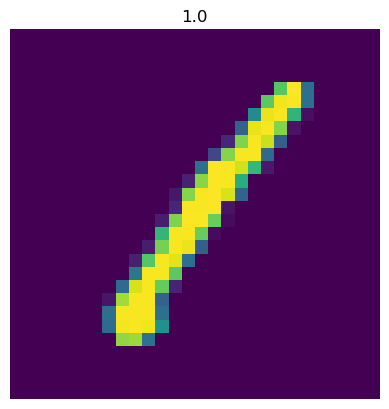

In [13]:
# resimi görselleştirelim
plt.imshow(features_numpy[0].reshape(28,28)) # 0. satırdaki örneği 28,28 görselleştirelim
plt.axis("off")
plt.title(str(targets_numpy[0])) # label, sınıf
plt.savefig("graph.png") # resimi kaydedelim
plt.show()

## Logistic Regression Modelinin Kurulması

lineer regresyon ile lojistik regresyon arasındaki fark lojistik regresyonda softmax fonksiyonunun olmasıdır. pytorch'da sınıf yazarken fark yoktur fakat loss fonksiyonunun içerisinde softmax fonksiyonu tanımlanmıştır. bu softmax fonksiyonunu kullanarak lojistik regresyon yapacağız.

In [14]:
class LogisticRegressionModel(nn.Module): # torch'un neural network kütüphanesiden Module'ü inherit eder
    
    def __init__(self, input_dim, out_dim): # constructor'ın içerisine super
        super(LogisticRegressionModel, self).__init__() # nn.Module'ün __init__() fonksiyonu çağrılır
        # Module'ün içerisindeki nesneleri kullanabiliriz
        
        # 10 tane sınıf olduğundan output_size = 10
        # 28 * 28 = 784 tane piksel input_size = 784
        self.linear = nn.Linear(input_dim, output_dim)
        
    # eğitim işlemi gerçekleşirken forward pytorch tarafından otomatik bir şekilde çağrılıyor
    def forward(self, x): # input (train veri seti) gönderebilmemiz için
        out = self.linear(x) # prediction
        return out # tahmini değerler 

In [15]:
input_dim = 28*28 # piksel sayısı
output_dim = 10  # sınıf sayısı 10 (0-9)

In [16]:
# logistic regression modelini oluşturduk
model = LogisticRegressionModel(input_dim, output_dim)

In [17]:
# cross entropy loss
error = nn.CrossEntropyLoss() # softmax
# forward'dan sonra error'e bakılır 
# dolayısıyla softmax fonksiyonumuzu kullanmış olacağız

eğer binary classification yapıyor olsaydık (2 tane sınıf (output) olsaydı) sigmoid fonksiyonu kullanılır fakat burada multi classification olduğundan softmax kullanılır ve CrossEntropyLoss'un içerisinde softmax bulunur.

In [18]:
# SGD Optimizer
learning_rate = 0.001

# parametre güncellemesi optimizer'ın içerisinde olur.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Logistic Regression Modelinin Eğitimi ve Testi

### Logistic Regression Modelinin Eğitimi

In [19]:
count = 0
loss_list=[]
iteration_list = []

for epoch in range(num_epochs): # tüm veri seti kaç kez train edilecek? num_epochs = 29
    # index sayısı, (resimler, bu resimlere karşılık gelen sınıflar)
    for i, (images, labels) in enumerate(train_loader):
        
        # Variables
        # gradient'leri tutabilmek için variable oluşturalım
        # view, reshape demektir.
        train = Variable(images.view(-1, 28*28)) # kaç tane resim varsa o kadar satır
        # 1 resim 28*28 pikselden oluştuğundan o kadarda sütun olmalı
        labels = Variable(labels)
        
        # optimizer'ın içerisinde güncellenmesi gereken parametreler var
        # bu parametrelere (w ve b) ilk değerlerini atıyalım
        optimizer.zero_grad() # bu parametrelere ilk değer olarak sıfır atıyorum
        
        # forward propagation
        # parametrelere ilk değerleri atanmıştı (optimizer'ın içerisinde weight'ler 0'dır)
        # modele train veri seti verilir ve output olarak tahmini değerler geri dönderilir
        outputs = model(train)
        # eğitimde gerçek değerlerle tahmini değerler karşılaştırılır
        # değerler farklıysa parametreler güncellenir aynı olması sağlanmaya çalışılır
        # loss azaltılır
        
        # softmax ve cross entropy loss
        loss = error(outputs, labels) # loss'u kullanarak gradientler hesaplanacak 
        
        # gradient'ler hesaplanır
        loss.backward() # loss'un parametrelere göre türevi alınır
        # gradient değerleri var
        
        # parametreler (w ve b) güncellenir
        optimizer.step()
        
        count +=1 # 
        
        
        # Prediction
        # veri hem train edilir hemde 50 adımda bir prediction işlemi gerçekleştirilir
        if count % 50 == 0: # count 50 ve katları ise prediction(tahmin) işlemi yapılır
            
            # accuracy değerini hesaplamak için
            correct = 0 # doğru tahmin sayısı
            total = 0 # toplam tahmin sayısı
            
            # Prediction
            for images, labels in test_loader:
                
                test = Variable(images.view(-1, 28*28)) # resimler
                # test: torch.Size([100, 784])
                
                # Forward propagation
                outputs = model(test) # tahmin edilen değerler
                # outputs, olasılıksal bir sonuçtur
                # lojistik regresyon sonucunda olasılıksal değerler ortaya çıkar
                # outputs: torch.Size([100, 10])
                
                # olasılıksal değerlerden 1'e en yakın değere bakılır.
                predicted = torch.max(outputs.data, 1)[1]
                # predicted: tensor([6, 6, 5, 5, 6, 6, 6, 5, 5
                # predicted: torch.Size([100])
                
                # 100 örnek kullanıldı dolayısıyla 100 tane tahmin yapıldı bu total'dır
                total += len(labels) # test veri setinin içerisinde kaç tane örnek olduğu bulunur
                # total: 100, 200...
                
                # bu 100 örnekten kaç tanesi doğru tahmin edildi
                correct += (predicted == labels).sum() # kaç tane doğru tahmin yapıldı
                # her döngüde doğru tahmin sayısı toplanır
                
            # accuracy
            accuracy = 100 * correct / float(total)
            
            # loss ve iterasyon sayısı
            loss_list.append(loss.data)
            iteration_list.append(count)
            
        
        if count % 500 == 0:
            # count 500'ün katı oldukça iterasyon, loss ve accuracy değerlerini yazdır
            print("Iteration: {} Loss: {} Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500 Loss: 1.8146382570266724 Accuracy: 67.13095092773438%
Iteration: 1000 Loss: 1.6224467754364014 Accuracy: 75.38095092773438%
Iteration: 1500 Loss: 1.3104503154754639 Accuracy: 78.10713958740234%
Iteration: 2000 Loss: 1.2075599431991577 Accuracy: 79.58333587646484%
Iteration: 2500 Loss: 1.0432839393615723 Accuracy: 80.66666412353516%
Iteration: 3000 Loss: 0.9415042400360107 Accuracy: 81.63095092773438%
Iteration: 3500 Loss: 0.9082298874855042 Accuracy: 82.3452377319336%
Iteration: 4000 Loss: 0.7559759616851807 Accuracy: 83.0%
Iteration: 4500 Loss: 0.9739794135093689 Accuracy: 83.52381134033203%
Iteration: 5000 Loss: 0.8067194223403931 Accuracy: 83.88095092773438%
Iteration: 5500 Loss: 0.7467281222343445 Accuracy: 84.27381134033203%
Iteration: 6000 Loss: 0.8815550208091736 Accuracy: 84.64286041259766%
Iteration: 6500 Loss: 0.6627237200737 Accuracy: 84.88095092773438%
Iteration: 7000 Loss: 0.7117974758148193 Accuracy: 85.0952377319336%
Iteration: 7500 Loss: 0.635372877120971

Loss değeri azalırken Accuracy değeri artar.

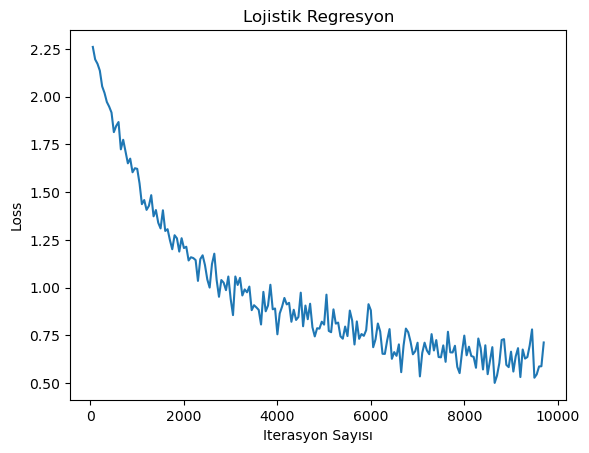

In [20]:
# görselleştirme
plt.plot(iteration_list, loss_list)
plt.xlabel("Iterasyon Sayısı")
plt.ylabel("Loss")
plt.title("Lojistik Regresyon")
plt.show()